In [1]:
import pandas as pd

# Load the datasets
confirmed_df = pd.read_csv("time_series_covid19_confirmed_global.csv")
deaths_df = pd.read_csv("time_series_covid19_deaths_global.csv")
recovered_df = pd.read_csv("time_series_covid19_recovered_global.csv")

# Inspect the data
print(confirmed_df.head())
print(deaths_df.head())
print(recovered_df.head())


  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  \
0        0        0        0        0  ...   209322  209340  209358  209362   
1        0        0        0        0  ...   334391  334408  334408  334427   
2        0        0        0        0  ...   271441  271448  271463  271469   
3        0        0        0        0  ...    47866   47875   47875   47875   
4        0        0        0        0  ...   105255  105277  105277  105277   

   3/4/23  3/5/23  3/6/23  3/7/23  3/8/23  3/9/23  
0  209369  209390  209406  2

In [2]:
import pandas as pd


def preprocess_time_series(df, value_name):
    # Melt the DataFrame to long format
    df_melted = pd.melt(
        df,
        id_vars=["Province/State", "Country/Region", "Lat", "Long"],
        var_name="Date",
        value_name=value_name,
    )

    # Convert 'Date' column to datetime
    df_melted["Date"] = pd.to_datetime(df_melted["Date"], format="%m/%d/%y")

    # Sort by date
    df_melted.sort_values(by=["Country/Region", "Province/State", "Date"], inplace=True)

    return df_melted


# Load the datasets
confirmed_df = pd.read_csv("time_series_covid19_confirmed_global.csv")
deaths_df = pd.read_csv("time_series_covid19_deaths_global.csv")
recovered_df = pd.read_csv("time_series_covid19_recovered_global.csv")

# Preprocess each DataFrame
confirmed_df = preprocess_time_series(confirmed_df, "Confirmed")
deaths_df = preprocess_time_series(deaths_df, "Deaths")
recovered_df = preprocess_time_series(recovered_df, "Recovered")

# Print columns to verify
print("Confirmed DataFrame columns:", confirmed_df.columns)
print("Deaths DataFrame columns:", deaths_df.columns)
print("Recovered DataFrame columns:", recovered_df.columns)


Confirmed DataFrame columns: Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed'], dtype='object')
Deaths DataFrame columns: Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Deaths'], dtype='object')
Recovered DataFrame columns: Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Recovered'], dtype='object')


In [3]:
def merge_in_chunks(df1, df2, chunk_size=5000):
    merged_df = pd.DataFrame()
    for start in range(0, len(df1), chunk_size):
        end = start + chunk_size
        chunk = df1.iloc[start:end]
        try:
            chunk = pd.merge(
                chunk,
                df2,
                on=["Province/State", "Country/Region", "Lat", "Long", "Date"],
                how="left",
            )
            merged_df = pd.concat([merged_df, chunk])
        except KeyError as e:
            print(f"KeyError: {e}")
            print(f"Columns in chunk: {chunk.columns}")
            print(f"Columns in df2: {df2.columns}")
            break
        except MemoryError:
            print(f"MemoryError at chunk {start}-{end}")
            break
    return merged_df


# Merge datasets
merged_df = merge_in_chunks(confirmed_df, deaths_df, chunk_size=5000)
merged_df = merge_in_chunks(merged_df, recovered_df, chunk_size=5000)

# Check the merged DataFrame
print(merged_df.head())


  Province/State Country/Region       Lat       Long       Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953 2020-01-22          0   
1            NaN    Afghanistan  33.93911  67.709953 2020-01-23          0   
2            NaN    Afghanistan  33.93911  67.709953 2020-01-24          0   
3            NaN    Afghanistan  33.93911  67.709953 2020-01-25          0   
4            NaN    Afghanistan  33.93911  67.709953 2020-01-26          0   

   Deaths  Recovered  
0       0        0.0  
1       0        0.0  
2       0        0.0  
3       0        0.0  
4       0        0.0  


In [4]:
# Feature Engineering
merged_df["Daily_Confirmed"] = (
    merged_df.groupby(["Country/Region", "Province/State"])["Confirmed"]
    .diff()
    .fillna(0)
)
merged_df["Daily_Deaths"] = (
    merged_df.groupby(["Country/Region", "Province/State"])["Deaths"].diff().fillna(0)
)
merged_df["Daily_Recovered"] = (
    merged_df.groupby(["Country/Region", "Province/State"])["Recovered"]
    .diff()
    .fillna(0)
)


In [5]:
import pandas as pd

# Load the main population data
population_df = pd.read_csv(
    "API_SP.POP.TOTL_DS2_en_csv_v2_87.csv", skiprows=4
)  # Skipping the first few rows to get to the data


In [6]:
# Load country metadata
country_metadata_df = pd.read_csv(
    "Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_87.csv"
    
)
print(country_metadata_df.head())


  Country Code                     Region          IncomeGroup  \
0          ABW  Latin America & Caribbean          High income   
1          AFE                        NaN                  NaN   
2          AFG                 South Asia           Low income   
3          AFW                        NaN                  NaN   
4          AGO         Sub-Saharan Africa  Lower middle income   

                                        SpecialNotes  \
0                                                NaN   
1  26 countries, stretching from the Red Sea in t...   
2  The reporting period for national accounts dat...   
3  22 countries, stretching from the westernmost ...   
4  The World Bank systematically assesses the app...   

                     TableName  Unnamed: 5  
0                        Aruba         NaN  
1  Africa Eastern and Southern         NaN  
2                  Afghanistan         NaN  
3   Africa Western and Central         NaN  
4                       Angola         Na

In [7]:
# Clean column names
population_df.columns = population_df.columns.str.strip()

# Merge on the country name or country code
merged_df = pd.merge(
    merged_df,
    population_df[["Country Name", "2000"]],
    how="left",
    left_on="Country/Region",
    right_on="Country Name",
)

# Rename columns for clarity if needed
merged_df.rename(columns={"2000": "Population"}, inplace=True)

print(merged_df.head())


  Province/State Country/Region       Lat       Long       Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953 2020-01-22          0   
1            NaN    Afghanistan  33.93911  67.709953 2020-01-23          0   
2            NaN    Afghanistan  33.93911  67.709953 2020-01-24          0   
3            NaN    Afghanistan  33.93911  67.709953 2020-01-25          0   
4            NaN    Afghanistan  33.93911  67.709953 2020-01-26          0   

   Deaths  Recovered  Daily_Confirmed  Daily_Deaths  Daily_Recovered  \
0       0        0.0              0.0           0.0              0.0   
1       0        0.0              0.0           0.0              0.0   
2       0        0.0              0.0           0.0              0.0   
3       0        0.0              0.0           0.0              0.0   
4       0        0.0              0.0           0.0              0.0   

  Country Name  Population  
0  Afghanistan  19542982.0  
1  Afghanistan  19542982.0  
2  Afghanis

In [8]:
merged_df.to_csv("merged_df_population.csv", index=False)

In [9]:
merged_df_with_population = pd.read_csv("merged_df_population.csv",low_memory=False)

In [10]:
merged_df_with_population.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Daily_Confirmed', 'Daily_Deaths',
       'Daily_Recovered', 'Country Name', 'Population'],
      dtype='object')

In [11]:
# Define thresholds
infection_percent_threshold = 0.1  # Set to 0.1% for now
daily_cases_threshold = 100  # Set an absolute threshold for daily cases
rolling_window = 7  # 7-day rolling window to smooth the data

# Calculate infection rate
merged_df_with_population["Infection_Rate"] = (
    merged_df_with_population["Daily_Confirmed"]
    / merged_df_with_population["Population"]
) * 100

# Apply rolling averages for smoothing
merged_df_with_population["Rolling_Daily_Confirmed"] = (
    merged_df_with_population["Daily_Confirmed"].rolling(window=rolling_window).mean()
)
merged_df_with_population["Rolling_Infection_Rate"] = (
    merged_df_with_population["Infection_Rate"].rolling(window=rolling_window).mean()
)

# Hotspot is True if either the infection rate or the absolute daily cases exceed the thresholds
merged_df_with_population["Hotspot"] = (
    merged_df_with_population["Rolling_Infection_Rate"] >= infection_percent_threshold
) | (merged_df_with_population["Rolling_Daily_Confirmed"] >= daily_cases_threshold)

# Display the results
print(merged_df_with_population["Hotspot"].value_counts())


Hotspot
False    316879
True      13448
Name: count, dtype: int64


In [12]:
merged_df_with_population.to_csv("merged_df_population_hotspots.csv", index=False)

In [13]:
merged_df_with_population.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Daily_Confirmed', 'Daily_Deaths',
       'Daily_Recovered', 'Country Name', 'Population', 'Infection_Rate',
       'Rolling_Daily_Confirmed', 'Rolling_Infection_Rate', 'Hotspot'],
      dtype='object')

In [40]:
# Remove rows with missing latitude or longitude values
merged_df_with_population_clean = merged_df_with_population.dropna(
    subset=["Lat", "Long"]
)


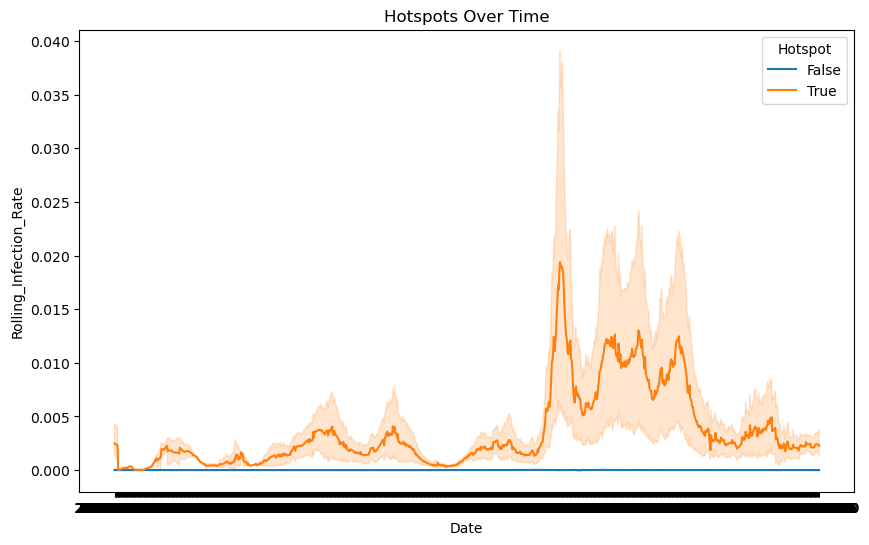

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the infection rates and hotspots over time
plt.figure(figsize=(10, 6))
sns.lineplot(x="Date", y="Rolling_Infection_Rate", hue="Hotspot", data=merged_df_with_population)
plt.title("Hotspots Over Time")
plt.show()


In [31]:
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features (X) and target (y)
X = merged_df_with_population[["Rolling_Infection_Rate", "Rolling_Daily_Confirmed"]]
y = merged_df_with_population["Hotspot"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Impute missing values in X_train and X_test
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Evaluate the model
accuracy = knn.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.9999596363232727


In [32]:
# New data (example)
new_data = [[0.12, 150]]  # List of values corresponding to the two features

# Impute missing values in the new data (if necessary)
new_data_imputed = imputer.transform(new_data)

# Scale the new data using the same scaler
new_data_scaled = scaler.transform(new_data_imputed)

# Predict whether the new area is a hotspot
hotspot_prediction = knn.predict(new_data_scaled)

# Print the prediction
print("Hotspot prediction:", hotspot_prediction)

# Optionally, if you want to see probabilities:
hotspot_probabilities = knn.predict_proba(new_data_scaled)
print("Hotspot prediction probabilities:", hotspot_probabilities)


Hotspot prediction: [ True]
Hotspot prediction probabilities: [[0. 1.]]


c:\Users\emada\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = merged_df_with_population[
    ["Lat", "Long", "Infection_Rate", "Rolling_Daily_Confirmed"]
]
y = merged_df_with_population["Hotspot"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Impute missing values in X_train and X_test
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predict probabilities
hotspot_probabilities = knn.predict_proba(X_test_scaled)[:, 1]


In [42]:
# Example new data with location
new_locations = [
    [34.0522, -118.2437, 0.15, 120]
]  # Example values: [Lat, Long, Infection_Rate, Rolling_Daily_Confirmed]

# Scale new data
new_locations_scaled = scaler.transform(new_locations)

# Predict hotspot probability
probability = knn.predict_proba(new_locations_scaled)[:, 1]

print("Hotspot probability:", probability[0])


Hotspot probability: 1.0


In [37]:
# Check for missing values
missing_lat = merged_df_with_population["Lat"].isnull().sum()
missing_long = merged_df_with_population["Long"].isnull().sum()

print(f"Missing latitude values: {missing_lat}")
print(f"Missing longitude values: {missing_long}")


Missing latitude values: 2286
Missing longitude values: 2286


In [38]:
# Remove rows with missing latitude or longitude values
merged_df_with_population_clean = merged_df_with_population.dropna(
    subset=["Lat", "Long"]
)


In [44]:
import folium

# Create a base map
map_center = [
    merged_df_with_population_clean["Lat"].mean(),
    merged_df_with_population_clean["Long"].mean(),
]
m = folium.Map(location=map_center, zoom_start=10)

# Add hotspot markers
for _, row in merged_df_with_population_clean[
    merged_df_with_population_clean["Hotspot"]
].iterrows():
    folium.Marker(
        location=[row["Lat"], row["Long"]],
        popup=f"Hotspot: {row['Infection_Rate']:.2f}%",
        icon=folium.Icon(color="red"),
    ).add_to(m)

# Save map
m.save("hotspot_map.html")


In [45]:
import pickle

# Save the trained KNN model
with open("knn_model1.pkl", "wb") as model_file:
    pickle.dump(knn, model_file)


In [46]:
# Save the scaler
with open("scaler1.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer

# Load your dataset
data = pd.read_csv("merged_df_population_hotspots.csv",low_memory=False)

# Handling missing values
imputer = SimpleImputer(strategy="mean")
numeric_cols = [
    "Population",
    "Infection_Rate",
    "Rolling_Daily_Confirmed",
    "Rolling_Infection_Rate",
]
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# Selecting features and target
X = data[
    [
        "Infection_Rate",
        "Rolling_Daily_Confirmed",
        "Rolling_Infection_Rate",
        "Population",
        "Lat",
        "Long",
    ]
]
y = data["Hotspot"]

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Training the RandomForest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     95124
        True       1.00      1.00      1.00      3975

    accuracy                           1.00     99099
   macro avg       1.00      1.00      1.00     99099
weighted avg       1.00      1.00      1.00     99099



In [17]:
from sklearn.impute import SimpleImputer

# Assuming X is your feature set
imputer = SimpleImputer(strategy="mean")  # or strategy='median'
X_imputed = imputer.fit_transform(X)


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming y is your target variable
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

knn_model = KNeighborsClassifier(n_neighbors=5)  # Adjust n_neighbors as needed
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00     95124
        True       0.99      0.99      0.99      3975

    accuracy                           1.00     99099
   macro avg       1.00      0.99      1.00     99099
weighted avg       1.00      1.00      1.00     99099



In [20]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(knn_model, X_scaled, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())


Cross-validation scores: [0.87677474 0.8018648  0.92599712 0.97204269 0.96915159]
Mean cross-validation score: 0.9091661889365252


c:\Users\emada\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ROC-AUC Score: 0.9222374396980413


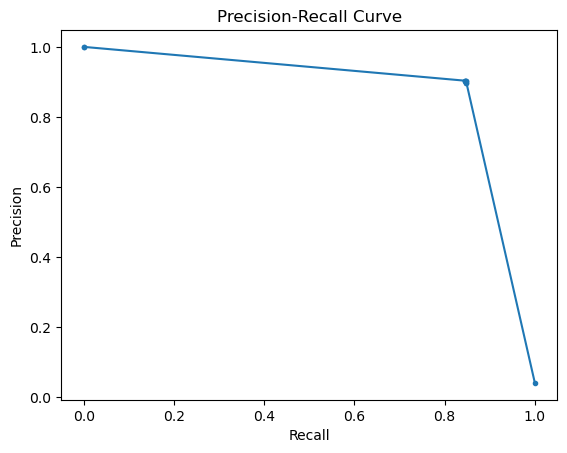

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {"n_neighbors": [3, 5, 7, 9, 11]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_scaled, y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters: {'n_neighbors': 11}
Best cross-validation score: 0.9172036033154903


In [23]:
import pandas as pd

feature_importances = pd.DataFrame(
    model.feature_importances_, index=X.columns, columns=["importance"]
).sort_values("importance", ascending=False)
print(feature_importances)


                         importance
Rolling_Daily_Confirmed    0.531762
Rolling_Infection_Rate     0.336735
Infection_Rate             0.105473
Population                 0.012990
Lat                        0.008051
Long                       0.004990


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import joblib  # For saving the model

# Load your dataset
# merged_df_with_population = pd.read_csv('path_to_your_merged_data.csv')

# Select features and target
features = ["Daily_Confirmed", "Infection_Rate", "Rolling_Daily_Confirmed"]
target = "Hotspot"

# Drop rows with NaN values in selected columns
df_model = merged_df_with_population.dropna(subset=features + [target])

# Define X and y
X = df_model[features]
y = df_model[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Save the model and scaler for use in the Flask app
joblib.dump(knn, "knn_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']